# Spaceship Titanic

**Kaggle competitions**

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

In [6]:
# Author: Martín Gamboa
# Date: October 18th, 2024

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC,SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import PrecisionRecallDisplay,RocCurveDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

data/train.csv
data/test.csv
data/sample_submission.csv


# Read data

In [7]:
#reading data
train_data = pd.read_csv(os.path.join(dirname,filenames[1]))
test_data = pd.read_csv(os.path.join(dirname,filenames[2]))

In [12]:
train_data_original = train_data.copy()
print(f"There are {train_data.isna().sum(axis=0).sum()} NaN values in the training data")
print(f"There are {test_data.isna().sum(axis=0).sum()} NaN values in the test data")

There are 1117 NaN values in the training data
There are 0 NaN values in the test data


# Preprocess

## Outliers treatment

We will process only relevant columns for our study

In [20]:
# There are some columns that are not needed to treat with outliers
# such as: PassengerId, HomePlanet, CryoSleep, Cabin, Destination, VIP, Name, Transported
# So columns that will be considered for outlier detection:
#   Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
col_outliers = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

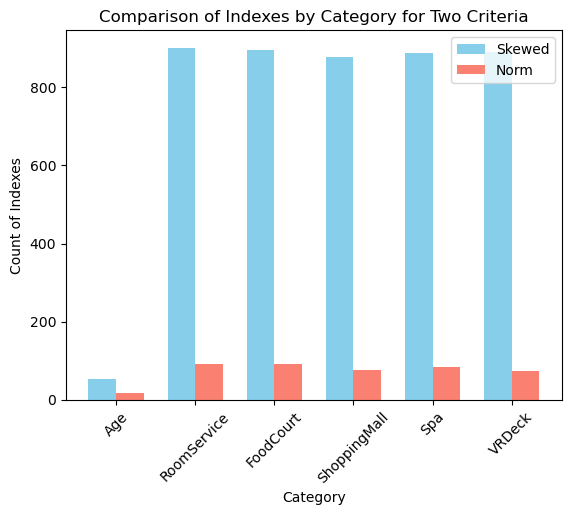

In [ ]:
def outliers_norm_threshold(dataset, cols):
    aux_data = dataset.copy()
    aux_data = aux_data[cols]
    #print(aux_data)
    mean_ds = aux_data.mean(axis=0)
    std_ds = aux_data.std(axis=0)
    #mean_ds, std_ds
    low_value = {}
    high_value = {}
    for j, name in enumerate(mean_ds.keys()):
        low_value[name] = max(mean_ds[name] - 3 * std_ds[name], 0)
        high_value[name] = mean_ds[name] + 3 * std_ds[name]
    return low_value, high_value

def outliers_norm_distro(dataset, colnames):
    """ 
    dataset: pd.DataFrame
    cols: pd.Series or list of column names where to search outliers
    -
    Returns indexes where the condition is not satisficed in each col in cols
    """
    low_norm, high_norm = outliers_norm_threshold(train_data, col_outliers)
    #low_norm , high_norm
    aux_data_norm={}
    for j, name in enumerate(low_norm.keys()):
        aux_data_norm[name] = dataset[(dataset[name] < low_norm[name]) | (dataset[name] > high_norm[name]) ].index
    return aux_data_norm
idx_norm_outliers = outliers_norm_distro(train_data, col_outliers)

# IQR
def outliers_skewed_threshold(dataset, colnames):
    aux_data_q = dataset.copy()
    quantile1 = aux_data_q[colnames].quantile(0.25)
    quantile3 = aux_data_q[colnames].quantile(0.75) 
    #print(quantile1, quantile3)
    # compute iqr
    iqr = quantile3 - quantile1
    up_limit_q = quantile3 + 1.5 * iqr
    low_limit_q = quantile1 - 1.5 * iqr
    for j, name in enumerate(low_limit_q.keys()):
        low_limit_q[name] = max(low_limit_q[name], 0)
    return low_limit_q, up_limit_q
def outliers_skewed_distro(dataset, colnames):
    low_limit, up_limit = outliers_skewed_threshold(dataset, colnames)
    aux_data_norm={}
    for j, name in enumerate(low_limit.keys()):
        aux_data_norm[name] = dataset[(dataset[name] < low_limit[name]) | (dataset[name] > up_limit[name]) ].index
    return aux_data_norm

idx_skewed_outliers = outliers_skewed_distro(train_data, col_outliers)

#print(idx_skewed_outliers)
len_skewed = {ikey: len(ival) for ikey, ival in zip(idx_skewed_outliers.keys(), 
                                              idx_skewed_outliers.values())}
len_norm = {ikey: len(ival) for ikey, ival in zip(idx_norm_outliers.keys(), 
                                              idx_norm_outliers.values())}
# compare the two outliers algorithms
# Extract categories and their respective counts
categories = list(len_skewed.keys())
counts_skewed = list(len_skewed.values())
counts_norm = list(len_norm.values())

# Number of categories
num_categories = len(categories)
# Create an array for positioning the bars on the x-axis
indices = np.arange(num_categories)
# Width of each bar
bar_width = 0.35

# Plotting the grouped bar chart
plt.bar(indices, counts_skewed, bar_width, label='Skewed', color='skyblue')
plt.bar(indices + bar_width, counts_norm, bar_width, label='Norm', color='salmon')
# Adding labels, title, and legend
plt.xlabel('Category')
plt.ylabel('Count of Indexes')
plt.title('Comparison of Indexes by Category for Two Criteria')
plt.xticks(indices + bar_width / 2, categories, rotation=45)  # Position x-axis labels
plt.legend()

########
# 
#        Mask data with Decision 
# 
########
# We will set that values as NaN's using Norm criteria because the % of data that will change is less
def set_outliers_as_nan(dataset, idx_outliers):
    for name in idx_outliers.keys():
        dataset.loc[idx_norm_outliers[name], name] = np.nan
    return dataset
#train_data = set_outliers_as_nan(train_data, idx_norm_outliers)

def remove_outlier(dataset, colname):
    low_limit, up_limit = outliers_norm_threshold(dataset, colname)
    for j, name in enumerate(low_limit.keys()):
        dataset = dataset[~((dataset[name] < low_limit[name]) | (dataset[name] > up_limit[name])) ]
        # Reset the index of the DataFrame
    dataset.reset_index(drop=True, inplace=True)
    return dataset
#train_data = remove_outlier(train_data, col_outliers)

def replace_outlier_with_stats(dataset, colnames, method='mean'):
    low_limit, up_limit = outliers_norm_threshold(dataset, colnames)
    
    for name in colnames:
        # Calculate the replacement value
        if method == 'mean':
            replacement_value = dataset[name].mean()
        elif method == 'median':
            replacement_value = dataset[name].median()
        else:
            raise ValueError("Method must be 'mean' or 'median'")
        
        # Replace outliers with the calculated statistic
        dataset[name] = dataset[name].where(
            (dataset[name] > low_limit[name]) | (dataset[name] < up_limit[name]),
            replacement_value
        )
    
    return dataset
train_data = replace_outlier_with_stats(train_data, col_outliers, method='mean')


In [31]:
############
#####
#####
#####   Adapting to preprocessing.py module
#####
#####
############

ble = outliers_skewed_distro(train_data, ['Age'])

import sys
sys.path.append('..')
from mymodule import *
outlier_removal = OutlierRemover('std', 1.5)

bla, accepted_idxs = outlier_removal.remove_outliers(train_data['Age'], border_cases=False)



In [14]:
#train_data=pd.DataFrame(train_data)
display(train_data)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,28.658146,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,28.658146,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


## Inspecting Data-table

In [15]:
colnames = list(train_data.columns)
colnames_test = list(test_data.columns)
print(" Columns train", colnames)
print(" Columns test", colnames_test)
X_full = train_data[colnames[:-1]]
y_full = train_data[colnames[-1]]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.30, random_state=42)

X_validation = test_data[colnames_test]


print(" Columns Xtr", list(X_train.columns))
print(" Columns Xte", list(X_validation.columns))

 Columns train ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']
 Columns test ['PassengerId', 'Transported']
 Columns Xtr ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
 Columns Xte ['PassengerId', 'Transported']


## NaN's treatment

NaN values [  0  87  93 100  92   0  93   0   0   0   0   0  94]
NaN values PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age               0
VIP              93
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name             94
dtype: int64


Text(0.5, 1.0, 'NaN Values Count in Each Column')

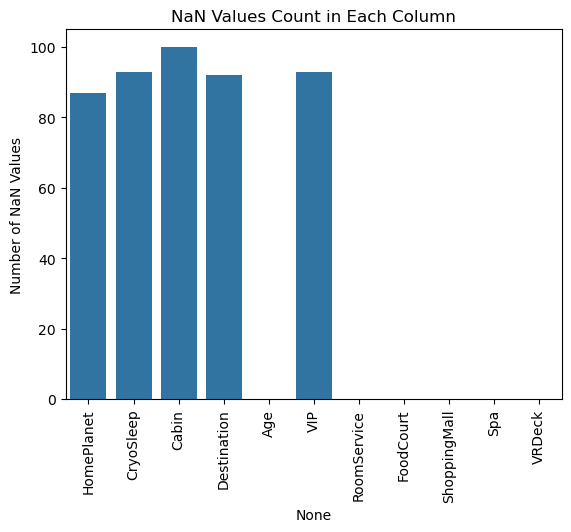

In [16]:
# Look at how many nan values we have in each category
# Approach 1
total_data = len(train_data) 
count_non_nans = np.array(train_data.count(axis=0) )
print("NaN values", total_data-count_non_nans)
# Approach 2
nan_counts = train_data[1:-1].isna().sum(axis=0)
print("NaN values", nan_counts)

sns.barplot(x=nan_counts[1:-1].index, y=nan_counts[1:-1].values)
plt.xticks(rotation=90) 
plt.ylabel('Number of NaN Values')
plt.title('NaN Values Count in Each Column')

In [17]:
# are there values that intersect?
# print(train_data[train_data.isna().any(axis=1)])
total_count_nan = train_data.isna().sum().sum()
intersect_count = (train_data.isna().sum(axis=1) > 1).sum()
print(intersect_count , "/", total_count_nan, " values intersect" )

28 / 559  values intersect


* The number of NaN values is not negligible so we will deal with them. 

# Preprocessing Data
We will convert all data in numerical values to fed our NN. Since names are all differents, we deleted that column from our data in the first try 

__Preprocessing__ [TODO]
- Analyze correlations between features
- Implement PCA to reduce dimensionality

__We will try 3 independent models__
1. SVM
2. KNN
3. Random Forest

In [18]:
def normalize_data(X_train_pp):
    ## PassengerId: Convert PassengerId by family 
    rename_passId = lambda name: int(name.split("_")[0])
    X_train_pp['PassengerId']= X_train_pp['PassengerId'].apply(rename_passId)
    
    ## HomePlanet (keeping NaN)
    # Generate multiple new features according the HomePlannet (OneHotEncoding)
    # ok print("HomePlanet", X_train_pp['HomePlanet'].isna().sum())
    mask_nan = X_train_pp['HomePlanet'].isna()
    X_train_pp = pd.get_dummies(X_train_pp, columns=['HomePlanet'], dtype=int)
    # Get all column names that start with 'HomePlanet_'
    homeplanet_columns = [col for col in X_train_pp.columns if col.startswith('HomePlanet_')]
    X_train_pp.loc[mask_nan, homeplanet_columns] = float('nan')
    # ok print("HomePlanet", X_train_pp[homeplanet_columns].isna().sum())
    
    ## Destination (keeping NaN)
    # Generate multiple new features according the Destination (OneHotEncoding)
    # ok print("Destination", X_train_pp.Destination.isna().sum())
    mask_nan = X_train_pp['Destination'].isna()
    X_train_pp = pd.get_dummies(X_train_pp, columns=['Destination'], dtype=int)
    # Get all column names that start with 'HomePlanet_'
    destination_columns = [col for col in X_train_pp.columns if col.startswith('Destination_')]
    X_train_pp.loc[mask_nan, destination_columns] = float('nan')
    # ok print("Destination", X_train_pp[destination_columns].isna().sum())
    
    ## CryoSleep & VIP
    #CryoSleep -> from bool to int
    label_mapping = {True: 1, False: 0}
    for ilabel in ['CryoSleep', 'VIP']:
        mask_nan = X_train_pp[ilabel].isna()
        X_train_pp[ilabel] = X_train_pp[ilabel].map(label_mapping)
        X_train_pp.loc[mask_nan, [ilabel]] = float('nan')
    
    ## Cabin
    # Split the Cabin column into three different columns = deck/num/side to have better resolution
    mask_nan = X_train_pp['Cabin'].isna()
    X_train_pp.Cabin = X_train_pp.Cabin.replace(to_replace = np.nan, value = 'nan/nan/nan')
    X_train_pp[['Deck', 'Num', 'Side']] = X_train_pp['Cabin'].str.split('/', expand=True)
    for clabel in ['Deck', 'Num', 'Side']:
        X_train_pp.loc[mask_nan, [clabel]] = float('nan')
    # Now let's use LabelEncoding for deck and side 
    label_encoder = LabelEncoder()
    # Fit the encoder and transform the 'deck' and 'side' columns
    X_train_pp['Deck'] = label_encoder.fit_transform(X_train_pp['Deck'])
    
    X_train_pp['Side'] = label_encoder.fit_transform(X_train_pp['Side'])
    X_train_pp.drop(columns=['Cabin'], inplace=True)
    for clabel in ['Deck', 'Side', 'Num']:
        X_train_pp.loc[mask_nan, [clabel]] = float('nan')
    
    return X_train_pp
# Remove Name from X_train and X_test
X_train_pp = X_train.copy()
X_test_pp = X_test.copy()
X_train_pp.drop(columns='Name', inplace=True)
X_test_pp.drop(columns='Name', inplace=True)
#X_train_svc = normalize_data(X_train_pp)
X_train_ = normalize_data(X_train_pp)
X_test_ = normalize_data(X_test_pp)
print("Orig", train_data.isna().sum(axis=0).sum())
print("Prep", X_train_.isna().sum(axis=0).sum()+X_test_.isna().sum(axis=0).sum())
#print("Prep", X_test_.isna().sum(axis=0).sum())
print(201*2+199*2+182*2-200) #-200 because I deleted Name column for the analysis
print(3288-2324)
#

KeyError: "['Name'] not found in axis"

In [19]:
preproc = True
if preproc:
    # Compute the correlation matrix
    corr_matrix = pd.DataFrame(X_train_).corr()

    # Plotting the correlation matrix as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', 
                cmap='coolwarm', cbar=True, square=True)
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # Set a correlation threshold (e.g., 0.85)
    threshold = 0.85

    # Find pairs of features that are highly correlated
    high_corr_pairs = np.where(np.abs(corr_matrix) > threshold)
    high_corr_pairs = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_pairs) if x != y and x < y]

    print("Highly correlated feature pairs (above the threshold):")
    for pair in high_corr_pairs:
        print(pair)

    ##########################
    ##########
    ########## Applying Preprocessing to the data.
    ##########
    ###########################
    # Assuming your dataset X (with 18 features) is stored in a pandas DataFrame
    # X = your dataframe with 18 features

    # Step 1: Standardize the data
    scaler = StandardScaler()
    X_scaled_ = scaler.fit_transform(X_train_)
    X_scaled = np.nan_to_num(X_scaled_, nan=-1.0)

    # Step 2: Apply PCA
    pca = PCA()  # You can also specify the number of components like PCA(n_components=5)
    X_pca = pca.fit_transform(X_scaled)

    # Step 3: Analyze the explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Step 4: Plot the explained variance and cumulative variance
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Individual explained variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative explained variance')
    plt.xlabel('Principal components')
    plt.ylabel('Explained variance ratio')
    plt.title('Explained Variance by Principal Components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

    # Step 5: Select the number of components (e.g., for pctg% variance)
    pctg=0.97
    n_components = np.argmax(cumulative_variance >= pctg) + 1
    print(f'Number of components to retain {pctg}% variance: {n_components}')

    # Step 6: Transform the dataset with the selected number of components
    pca_final = PCA(n_components=n_components)
    X_reduced = pca_final.fit_transform(X_scaled)

    print(f"Original shape: {X_train_.shape}")
    print(f"Reduced shape after PCA: {X_reduced.shape}")

NameError: name 'X_train_' is not defined

There are no notable correlations between the features and two of the eighteen features could be left out since they do not explain 99% of the variance observed in the data, therefore we will not eliminate any component since there will be no notable difference in the processing.

## Data Analysis

Look at the original data. We inspect the data in different formats

Index(['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age',
       'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Name'],
      dtype='object')
6217 8691


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Age', ylabel='Count'>

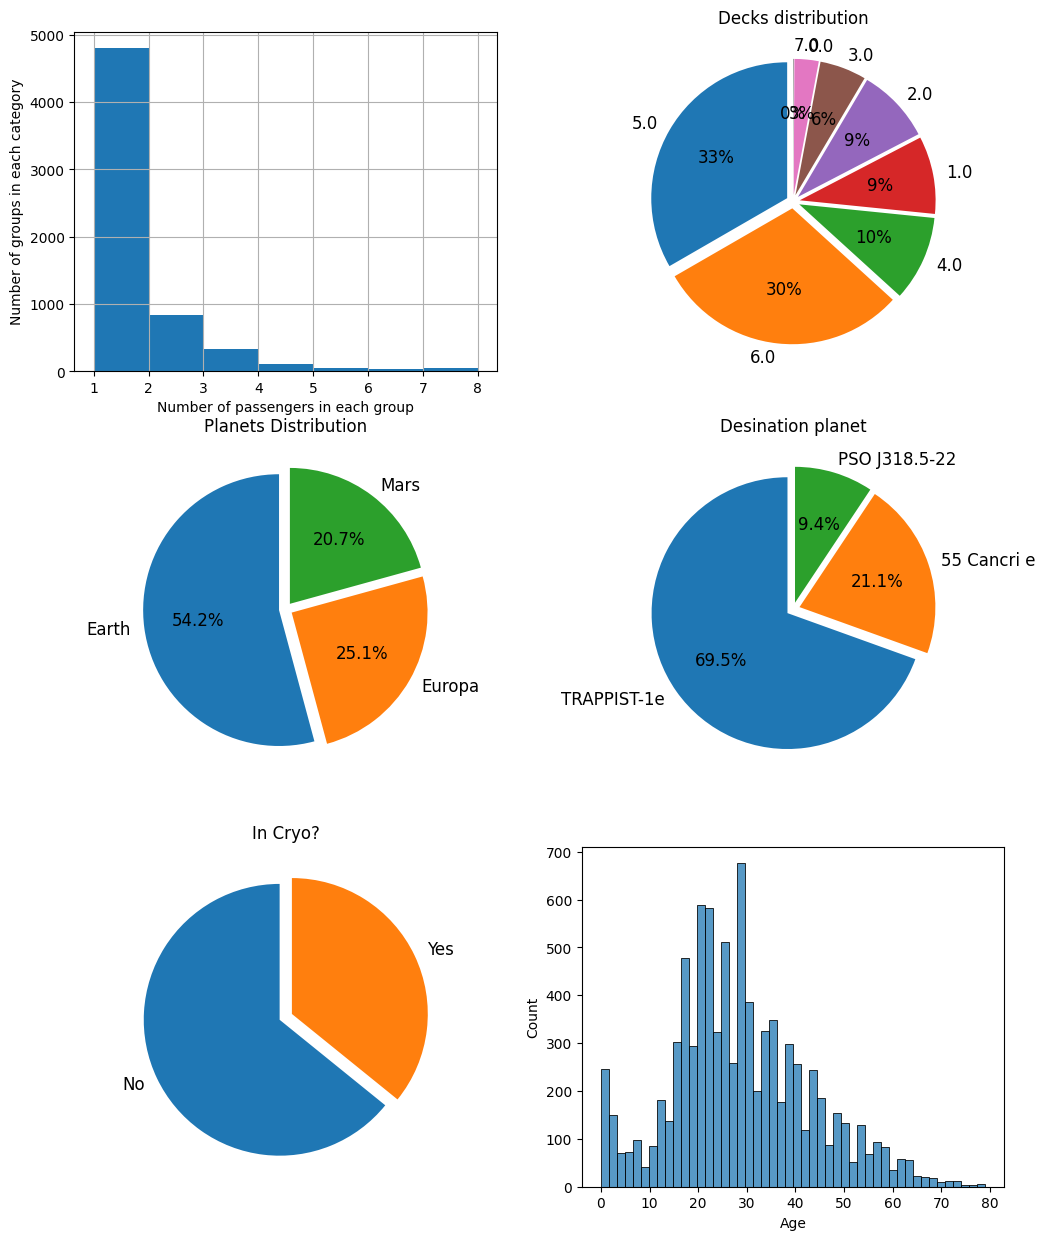

In [11]:
# Load Data to plot using Seaborn
print(X_full.columns)#X_train.columns, X_full.columns, train_data.columns
# 1. How many groups (look at pp from gggg_pp)
prevValueGroup = int(X_full['PassengerId'].iloc[0].split('_')[1])
one_in_group = []
two_in_group = []
thr_in_group = []
fou_in_group = []
fiv_in_group = []
six_in_group = []
sev_in_group = []
eig_in_group = []
for j, idpass in enumerate(X_full['PassengerId'][1:-1]):
    countId, groupId = [int(x) for x in idpass.split('_')]
    partialGroup = groupId
    if (prevValueGroup == 1) & (partialGroup == 1):
        one_in_group.append(prevValueGroup)
    if (prevValueGroup == 2) & (partialGroup == 1):
        two_in_group.append(prevValueGroup)
    if (prevValueGroup == 3) & (partialGroup == 1):
        thr_in_group.append(prevValueGroup)
    if (prevValueGroup == 4) & (partialGroup == 1):
        fou_in_group.append(prevValueGroup)
    if (prevValueGroup == 5) & (partialGroup == 1):
        fiv_in_group.append(prevValueGroup)
    if (prevValueGroup == 6) & (partialGroup == 1):
        six_in_group.append(prevValueGroup)
    if (prevValueGroup == 7) & (partialGroup == 1):
        sev_in_group.append(prevValueGroup)
    if (prevValueGroup == 8) & (partialGroup == 1):
        eig_in_group.append(prevValueGroup)
    if (prevValueGroup > 8):
        print("No group", j, prevValueGroup)
    prevValueGroup = partialGroup
two_in_group.append(int(X_full['PassengerId'].iloc[-1].split('_')[1]))
joint_groups = one_in_group+ two_in_group+ thr_in_group+ fou_in_group+\
               fiv_in_group+ six_in_group+ sev_in_group+ eig_in_group
fir_four = len(one_in_group) + len(two_in_group) + len(thr_in_group) + len(fou_in_group)
sec_four = len(fiv_in_group) + len(six_in_group) + len(sev_in_group) + len(eig_in_group)
print(fir_four+sec_four, len(X_full['PassengerId'][1:-1]))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12,15))
ax = ax.ravel()
ax[0].hist(joint_groups, bins = 7)
ax[0].set_xlabel("Number of passengers in each group")
ax[0].set_ylabel("Number of groups in each category")
ax[0].grid()
#joint_groups_df = pd.DataFrame({'groups': joint_groups})
#fig,ax1 = plt.subplots(ncols=1,figsize=(8,4))
#val1 = joint_groups_df.value_counts()
#val1.plot(kind='pie',label="",
#          textprops={'fontsize':10},
#          explode=(0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01), 
#          autopct='%1.1f%%',  # Shows percentage
#          pctdistance=0.85,   # Adjust distance of the percentage text from the center
#          labeldistance=1.1,  # Adjust distance of the labels from the center
#          startangle=90,      # Rotate the start angle
#          ax = ax1)
#ax1.legend(loc='best', bbox_to_anchor=(1, 0.5), labels=val1.index)

# 2. From which planet comes from
# Step 1: Count occurrences of each category
counts = X_full['HomePlanet'].value_counts()
# Step 2: Plot the pie chart
ax[2].pie(counts, 
        labels=counts.index,  # Labels are the category names (e.g., Europa, Earth)
        autopct='%1.1f%%',    # Display percentages on the chart
        startangle=90,        # Start the pie chart from the top
        explode=[0.05] * len(counts),  # Optional: Separate the slices slightly
        textprops={'fontsize': 12})  # Font size for labels
ax[2].set_title('Planets Distribution')  # Optional: Add a title

# 3. Deck distros (pie plot)
counts_deck = X_train_['Deck'].value_counts()
ax[1].pie(counts_deck,
         labels=counts_deck.index,
          autopct='%1.0f%%',
          startangle=90,
          explode=[0.05] * len(counts_deck),
         textprops={'fontsize': 12})
ax[1].set_title("Decks distribution")
# 4. Destination planet
counts_dest = X_full['Destination'].value_counts()
ax[3].pie(counts_dest,
         labels=counts_dest.index,
         autopct='%1.1f%%',
         startangle=90,
         explode=[0.05] * len(counts_dest),
         textprops={'fontsize':12})
ax[3].set_title("Desination planet")

# 5. Cryo Sleep (count)
counts_cryo = X_full['CryoSleep'].value_counts()
label_mapping = {True: 'Yes', False: 'No'}
mapped_labels = counts_cryo.index.map(label_mapping)
ax[4].pie(counts_cryo,
         labels=mapped_labels,#counts_cryo.index,
         startangle=90,
         explode=[0.05] * len(counts_cryo),
         textprops={'fontsize':12})
ax[4].set_title("In Cryo?")

# 6. How much it cost in total and in each topic (cumulative histogram)
sns.histplot(data=X_full['Age'], ax = ax[5])


## Normalization/Standarization of data
We will use standar scaler from **scikit-learn** (mean = 0 and standar deviation = 1)

In [12]:
scaler = StandardScaler()
cols_to_norm = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
X_train_scaled = scaler.fit_transform(X_train_)
X_test_scaled = scaler.fit_transform(X_test_)
print(np.isnan(X_train_scaled).sum(axis=0).sum()+np.isnan(X_test_scaled).sum(axis=0).sum())

2166


In [13]:
# Convert Y data into numerical representation. Since it is True/False, it is easy
y_train_true = y_train.astype(int)
y_test_true = y_test.astype(int)
print(y_test_true.shape)

(2608,)


In [14]:
from sklearn.ensemble import IsolationForest

# Initialize the IsolationForest model
z_scores = np.abs(X_train_scaled)
mask = np.where(X_train_scaled[(z_scores < 100).all(axis=1)])[0]
print(X_train_scaled[(z_scores < 100).all(axis=1)].shape, X_train_scaled.shape)
print(mask.shape, X_train_scaled.shape)
#X_clean = X[(z_scores < 3).all(axis=1)]


(5405, 18) (6085, 18)
(97290,) (6085, 18)


# Build ML algorithm


In [15]:
def compute_metrics(y_true, y_pred, mode='binary', y_prob=None):
    precision = precision_score(y_true, y_pred, average=mode)
    recall = recall_score(y_true, y_pred, average=mode)
    f1 = f1_score(y_true, y_pred, average=mode)
    accuracy = accuracy_score(y_true, y_pred)
    if y_prob is None:
        roc_auc = roc_auc_score(y_true, y_pred)
    else: 
        roc_auc = roc_auc_score(y_true, y_prob)
    
    return [precision, recall, f1, accuracy, roc_auc]


## 1. SVC and LinearSVC

In [16]:
def apply_imputation(X, strategy='mean'):
    """It applies imputation to handle NaN in SVC models.
    
    It returns 'imp' object to transform data like: imp.transform(X)"""
    
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    imp = imp.fit(X)
    x_imp = imp.transform(X)
    return x_imp

def apply_svc_lsvc(x_train, x_test, y_train, 
              kernel='rbf', C=1.0):
    
    x_train_imp = apply_imputation(x_train)
    x_test_imp = apply_imputation(x_test)
    
    clf_svc = SVC(kernel=kernel, C=C, max_iter=100000)
    clf_svc.fit(x_train_imp, np.array(y_train))
    clf_lsvc = LinearSVC(C=C, max_iter=100000)
    clf_lsvc.fit(x_train_imp, np.array(y_train))
    
    # Make predictions
    y_pred_svc = clf_svc.predict(x_test_imp)
    y_pred_lsvc = clf_lsvc.predict(x_test_imp)

    return y_pred_svc, y_pred_lsvc, clf_svc, clf_lsvc

metrics_svc_methods = []
metrics_lsvc_methods = []
models_svc = []
models_lsvc = []
cvals = [0.1, 0.6, 1.0,10.0]
for c in cvals:
    y_pred_svc, y_pred_lsvc,clf_svc, clf_lsvc = apply_svc_lsvc(X_train_scaled, X_test_scaled, 
                                             y_train_true, C=c)
    # Compute metrics
    # SVC
    metrics_svc = compute_metrics(y_test_true, y_pred_svc)
    # LinearSVC
    metrics_lsvc = compute_metrics(y_test_true, y_pred_lsvc)
    metrics_svc_methods.append(metrics_svc)
    metrics_lsvc_methods.append(metrics_lsvc)
    models_svc.append(clf_svc)
    models_lsvc.append(clf_lsvc)
    
print("Done it.")

Done it.


In [17]:
#print(metrics_svc_methods[:][3])
accuracy_idx = 3
best_svc_model_idx = np.argmax(metrics_svc_methods, axis=0)[accuracy_idx]
best_svc_model = models_svc[best_svc_model_idx]
metrics_svc = metrics_svc_methods[best_svc_model_idx]
print(cvals[best_svc_model_idx])

best_lsvc_model_idx = np.argmax(metrics_lsvc_methods, axis=0)[accuracy_idx]
best_lsvc_model = models_lsvc[best_lsvc_model_idx]
metrics_lsvc = metrics_lsvc_methods[best_lsvc_model_idx]
print(cvals[best_lsvc_model_idx])

1.0
0.6


(2608,) (2608,)


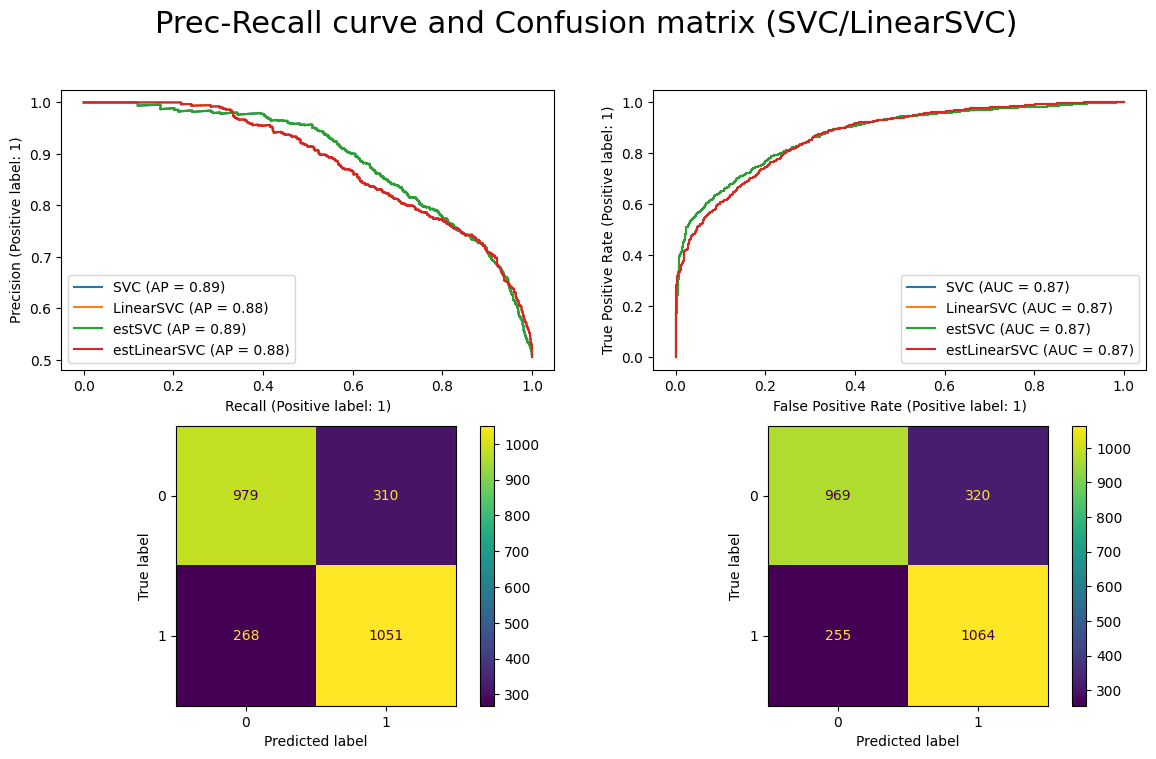

In [18]:
#X = X_reduced#np.nan_to_num(X_train_svc_scaled, nan=-1.0)
clf_svc = best_svc_model
clf_lsvc = best_lsvc_model
classif_svc = clf_svc.decision_function(apply_imputation(X_test_scaled))
classif_lsvc = clf_lsvc.decision_function(apply_imputation(X_test_scaled))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,8))
fig.suptitle("Prec-Recall curve and Confusion matrix (SVC/LinearSVC)", size = 22)
_ = PrecisionRecallDisplay.from_predictions(
    y_test_true, classif_svc, name="SVC", ax=ax[0,0])
_ = PrecisionRecallDisplay.from_predictions(
    y_test_true, classif_lsvc, name="LinearSVC", ax=ax[0,0])

_ = RocCurveDisplay.from_predictions(y_test_true, classif_svc, 
                                     name = "SVC", ax=ax[0,1])
_ = RocCurveDisplay.from_predictions(y_test_true, classif_lsvc,  
                                     name = "LinearSVC", ax=ax[0,1])
print(y_test_true.shape, y_pred_svc.shape)
_ = ConfusionMatrixDisplay.from_predictions(y_test_true, y_pred_svc, ax=ax[1,0])
_ = ConfusionMatrixDisplay.from_predictions(y_test_true, y_pred_lsvc, ax=ax[1,1])

#####
### From estimator
_ = PrecisionRecallDisplay.from_estimator(
    clf_svc, apply_imputation(X_test_scaled), y_test_true, 
    name="estSVC", ax=ax[0,0])
_ = PrecisionRecallDisplay.from_estimator(
    clf_lsvc, apply_imputation(X_test_scaled), y_test_true, 
    name="estLinearSVC", ax=ax[0,0])

_ = RocCurveDisplay.from_estimator(clf_svc, apply_imputation(X_test_scaled), y_test_true, 
                                     name = "estSVC", ax=ax[0,1])
_ = RocCurveDisplay.from_estimator(clf_lsvc, apply_imputation(X_test_scaled), y_test_true,  
                                     name = "estLinearSVC", ax=ax[0,1])

In [19]:
# Create a DataFrame
metrics_data = {
    "Metric": ["Precision", "Recall", "F1 Score", "Accuracy", "ROC AUC"],
    "SVC": metrics_svc,
    "LinearSVC": metrics_lsvc
}

metrics_df = pd.DataFrame(metrics_data)
models_df = pd.DataFrame({"SVC": [best_svc_model], "LSVC": [best_lsvc_model] })
# Display the table
display(metrics_df)

,Metric,SVC,LinearSVC
0,Precision,0.775256,0.768786
1,Recall,0.802881,0.806672
2,F1 Score,0.788827,0.787273
3,Accuracy,0.782592,0.779525
4,ROC AUC,0.782356,0.779209


===============================================================================

## 2. K-Nearest Neighbors

In [20]:
def apply_imputer_knn(X):
    from sklearn.impute import KNNImputer
    # define imputer
    imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
    # fit on the dataset
    imputer.fit(X)
    # transform the dataset
    x_imp = imputer.transform(X)
    return x_imp

def apply_knn(x_train, y_train, x_test, k_neighbors=1):
    # Initialize model
    clf_knn = KNeighborsClassifier(n_neighbors=k_neighbors)
    
    # Fit model
    clf_knn.fit(x_train, y_train)
    
    # Predict
    y_pred = clf_knn.predict(x_test)
    
    return y_pred, clf_knn

kvals = [1,3,7, 9, 11, 15]
metrics_knn_methods = []
models_knn = []
for ine in kvals:
    # apply Imputer to x_train, x_test
    x_train_imp = apply_imputer_knn(X_train_scaled)
    x_test_imp = apply_imputer_knn(X_test_scaled)
    
    y_pred, clf_knn = apply_knn(x_train_imp, y_train_true, 
                                x_test_imp, k_neighbors=ine)
    # Compute performance metrics
    # For ROC AUC, we need the predicted probabilities
    y_prob = clf_knn.predict_proba(x_test_imp)[:, 1]  # Probability of class 1
    
    #roc_auc = roc_auc_score(y_test_true, y_prob)
    imetrics_knn = compute_metrics(y_test_true, y_pred, y_prob=y_prob)
    metrics_knn_methods.append(imetrics_knn)
    models_knn.append(clf_knn)

print("Done it.")

Done it.


In [21]:
best_knn_model_idx = np.argmax(metrics_knn_methods,axis=0)[accuracy_idx]
best_knn_model = models_knn[best_knn_model_idx]
metrics_knn = metrics_knn_methods[best_knn_model_idx]
print(kvals[best_knn_model_idx])
# Add data to metrics_data
metrics_df["KNN"] =  metrics_knn
models_df["KNN"] = best_knn_model 

11


In [22]:
display(metrics_df)

,Metric,SVC,LinearSVC,KNN
0,Precision,0.775256,0.768786,0.802839
1,Recall,0.802881,0.806672,0.771797
2,F1 Score,0.788827,0.787273,0.787012
3,Accuracy,0.782592,0.779525,0.788727
4,ROC AUC,0.782356,0.779209,0.871501


We built two models: a) using KNN and b) using KNRadious. We will continue with KNN because it showed better performance with `n_neighbors = 11`. To say that we use AUC parameter, accuracy and precision. 

==============================================================================

## 3. Random Forest 

In [23]:
def apply_impute_rf(X):
    # Impute missing values using IterativeImputer
    imputer = IterativeImputer()
    X_imputed = imputer.fit_transform(X)
    return X_imputed

def apply_rf(x_train, y_true, x_test):
    
    # Initialization
    clf_rf = RandomForestClassifier(n_estimators=iest, random_state=42)
    
    # Fit the model
    clf_rf.fit(x_train, y_true)
    # Step 3: predict
    y_pred = clf_rf.predict(x_test)
    # Step 4: predict probabilities for ROC AUC
    y_prob = clf_rf.predict_proba(x_test)[:, 1]
    
    return y_pred, y_prob, clf_rf
    
estimators_list = [50,100,200,500] 
metrics_rf = []
models_rf = []
for i,iest in enumerate(estimators_list):
    # Impute missing values
    x_train_imp = apply_impute_rf(X_train_scaled)
    x_test_imp = apply_impute_rf(X_test_scaled)

    y_pred, y_prob, clf_rf = apply_rf(x_train_imp, y_train_true, 
                                     x_test_imp)
    # Compute performance metrics
    imetrics_rf = compute_metrics(y_test_true, y_pred, y_prob=y_prob)

    metrics_rf.append(imetrics_rf)
    models_rf.append(clf_rf)
print("Done it.")

Done it.


In [24]:
best_rf_model_idx = np.argmax(metrics_rf,axis=0)[accuracy_idx]
print(best_rf_model_idx, models_rf)
best_rf_model = models_rf[best_rf_model_idx]
metrics_rf_best = metrics_rf[best_rf_model_idx]
print(estimators_list[best_rf_model_idx])
# Add data to metrics_data
metrics_df["RF"] =  metrics_rf_best
models_df["RF"] = [best_rf_model]

3 [RandomForestClassifier(n_estimators=50, random_state=42), RandomForestClassifier(random_state=42), RandomForestClassifier(n_estimators=200, random_state=42), RandomForestClassifier(n_estimators=500, random_state=42)]
500


## 4. Gradient Boosting

In [25]:
def apply_hgbc(x_train, y_true, x_test, max_iter=100, 
               minleaf= 1, learning_rate=1.0, mdepth=2):
    clf_hgbc = HistGradientBoostingClassifier(min_samples_leaf=minleaf,
                                      max_depth=mdepth,
                                      learning_rate=learning_rate,
                                      max_iter=max_iter)
    clf_hgbc.fit(x_train, y_true)  
    # Prediction
    y_pred = clf_hgbc.predict(x_test)
    
    return y_pred, clf_hgbc

def apply_gbc(x_train, y_train, x_test, n_estimators=100,
             learning_rate=1.0, max_depth=1, random_state=0):
    clf_gbc = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate,
                                        max_depth=max_depth, random_state=rndm_state)
    clf_gbc.fit(x_train, y_train)
    # Prediction
    y_pred = clf_gbc.predict(x_test)
    return y_pred, clf_gbc

x_train_impute = apply_impute_rf(X_train_scaled)
x_test_impute = apply_impute_rf(X_test_scaled)

max_iters = [4, 200]
mineafs = [1,4]
lrs = [0.3,1.0]
maxdepts = [2,10]
metrics_hgbc = []
models_hgbc = []
# HistGradientBoostingClassifier
for imax in max_iters:
    for imean in mineafs:
        for ilr in lrs:
            for imaxd in maxdepts:
                #print(f'max_iters {imax} - minleaf {imean} - lr {ilr} - max_depth {imaxd}')
                y_pred, clf_hgbc = apply_hgbc(x_train_impute, y_train_true, x_test_impute, 
                       max_iter=imax, minleaf=imean, learning_rate=ilr, mdepth=imaxd)
                metrics_hgbc.append(compute_metrics(y_test_true, y_pred))
                models_hgbc.append(clf_hgbc)
print("Done HGBC")
# GradientBoostingClassifier
k_estimators=[20,100,150]
rndm_state=0
metrics_gbc = []
models_gbc = []
for iest in k_estimators:
    for ilr in lrs:
        for imaxd in maxdepts:
            #print(f'estimator {iest} - lr {ilr} - max_depth {imaxd}')
            y_pred, clf_gbc = apply_gbc(x_train_impute, y_train_true, x_test_impute, 
                   n_estimators=iest, learning_rate=ilr,
                    max_depth=imaxd, random_state=rndm_state)
            metrics_gbc.append(compute_metrics(y_test_true, y_pred))
            models_gbc.append(clf_gbc)
print("Done GBC")
print("Done it.")

Done HGBC
Done GBC
Done it.


In [26]:
#HGBC
best_hgbc_model_idx = np.argmax(metrics_hgbc,axis=0)[accuracy_idx]
best_hgbc_model = models_hgbc[best_hgbc_model_idx]
metrics_hgbc_best = metrics_hgbc[best_hgbc_model_idx]
metrics_df["HGBC"] =  metrics_hgbc_best
models_df["HGBC"] = [best_hgbc_model]
# GBC
best_gbc_model_idx = np.argmax(metrics_gbc,axis=0)[accuracy_idx]
best_gbc_model = models_gbc[best_gbc_model_idx]
metrics_gbc_best = metrics_gbc[best_gbc_model_idx]
metrics_df["GBC"] =  metrics_gbc_best
models_df["GBC"] = [best_gbc_model]

# Results

In [27]:
display(pd.DataFrame(metrics_df))
display(models_df)

,Metric,SVC,LinearSVC,KNN,RF,HGBC,GBC
0,Precision,0.775256,0.768786,0.802839,0.817600,0.810683,0.841927
1,Recall,0.802881,0.806672,0.771797,0.774829,0.782411,0.755118
2,F1 Score,0.788827,0.787273,0.787012,0.795640,0.796296,0.796163
3,Accuracy,0.782592,0.779525,0.788727,0.798696,0.797546,0.804448
4,ROC AUC,0.782356,0.779209,0.871501,0.888618,0.797722,0.805022


,SVC,LSVC,KNN,RF,HGBC,GBC
0,SVC(max_iter=100000),"LinearSVC(C=0.6, max_iter=100000)",KNeighborsClassifier(n_neighbors=11),"(DecisionTreeClassifier(max_features='sqrt', r...",HistGradientBoostingClassifier(learning_rate=0...,([DecisionTreeRegressor(criterion='friedman_ms...


# KFold with best models

In [28]:
ll = [X_train_scaled, X_test_scaled, y_train_true, y_test_true]
for il in ll:
    print(type(il))
# Concatenate X_array
X_array = np.concatenate((X_train_scaled, X_test_scaled))
print(X_train_scaled.shape, X_test_scaled.shape, 
      X_array.shape)
# Concatenate Y_array
Y_array = pd.concat([y_train_true, y_test_true]).reset_index(drop=True)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
(6085, 18) (2608, 18) (8693, 18)


In [29]:
for i,j in zip(models_df.columns.values, models_df.values[0]):
    print(i, "\t", j)

SVC 	 SVC(max_iter=100000)
LSVC 	 LinearSVC(C=0.6, max_iter=100000)
KNN 	 KNeighborsClassifier(n_neighbors=11)
RF 	 RandomForestClassifier(n_estimators=500, random_state=42)
HGBC 	 HistGradientBoostingClassifier(learning_rate=0.3, max_depth=2, max_iter=200,
                               min_samples_leaf=1)
GBC 	 GradientBoostingClassifier(learning_rate=0.3, max_depth=10, n_estimators=150,
                           random_state=0)


In [30]:
# Get all the models
models = models_df.values[0]
dfs = []
best_score=0.0
for name, model in zip(models_df.columns.values, models_df.values[0]):
    kfold = model_selection.KFold(n_splits=15, shuffle=True, random_state=0)
    x_impute = apply_impute_rf(X_array)
    cv_result = model_selection.cross_validate(model, x_impute, Y_array.values, cv=kfold, scoring='accuracy') 
    this_df = pd.DataFrame(cv_result)
    this_df['model'] = name
    dfs.append(this_df)
    print(name, model)
    # Calculate mean accuracy for this model
    mean_accuracy = this_df['test_score'].mean()
    print(f"Model: {name}, Mean Accuracy: {mean_accuracy}")
    
    # Update best model if this model has a higher mean accuracy
    if mean_accuracy > best_score:
        best_score = mean_accuracy
        best_model = (name, model)
        
final = pd.concat(dfs, ignore_index=True)
print("Done it.")

SVC SVC(max_iter=100000)
Model: SVC, Mean Accuracy: 0.8004143092529729
LSVC LinearSVC(C=0.6, max_iter=100000)
Model: LSVC, Mean Accuracy: 0.7893689079467175
KNN KNeighborsClassifier(n_neighbors=11)
Model: KNN, Mean Accuracy: 0.7861505171421198
RF RandomForestClassifier(n_estimators=500, random_state=42)
Model: RF, Mean Accuracy: 0.8052462628789231
HGBC HistGradientBoostingClassifier(learning_rate=0.3, max_depth=2, max_iter=200,
                               min_samples_leaf=1)
Model: HGBC, Mean Accuracy: 0.8073154269152126
GBC GradientBoostingClassifier(learning_rate=0.3, max_depth=10, n_estimators=150,
                           random_state=0)
Model: GBC, Mean Accuracy: 0.7994943719849917
Done it.


In [31]:
#final_with_outlier = final.copy()
#final_with_outlier_nan = final.copy()
#final_with_outlier_removed = final.copy()
final_with_outlier_replaced_mean = final.copy()
display(final[40:])

,fit_time,score_time,test_score,model
40,0.002085,0.056324,0.792746,KNN
41,0.002077,0.055395,0.808290,KNN
42,0.002137,0.056695,0.773748,KNN
43,0.002191,0.056437,0.791019,KNN
44,0.002251,0.056010,0.770294,KNN
45,10.741995,0.118073,0.836207,RF
46,10.527068,0.121191,0.784483,RF
47,10.552850,0.127983,0.820690,RF
48,10.546120,0.118853,0.777586,RF
49,10.565223,0.117209,0.800000,RF


In [32]:
best_model_outlier_removed = best_model

=======================================================================

# Application to data 

Run best model with `X_validation_scaled`  

In [33]:
import xgboost as xgb
from xgboost import XGBClassifier
# Initialize the XGBoost classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

# Train the model
#X_train_scaled, X_test_scaled, y_train_true, y_test_true
#x_impute = apply_impute_rf(X_array)
kfold_xgb = model_selection.KFold(n_splits=15, shuffle=True, random_state=0)
cv_result = model_selection.cross_validate(model, X_train_scaled, 
                                           y_train_true.values, 
                                           cv=kfold_xgb, scoring='accuracy') 

new_df = pd.DataFrame(cv_result)
new_df['model'] = name
#dfs.append(this_df)print(name, model)
# Calculate mean accuracy for this model
mean_accuracy = this_df['test_score'].mean()
print("Mean_ accuracy", mean_accuracy)    
# Make predictions on the test set
#y_pred_xgbc = model.predict(X_test_scaled)

# Calculate accuracy
#print("accuracy", accuracy_score(y_test_true, y_pred_xgbc))

Mean_ accuracy 0.7994943719849917


In [34]:
print(best_model)

('HGBC', HistGradientBoostingClassifier(learning_rate=0.3, max_depth=2, max_iter=200,
                               min_samples_leaf=1))


In [35]:
# Normalize data
X_validation_ = X_validation.copy()
X_validation_.drop(columns='Name', inplace=True)
X_validation_ = normalize_data(X_validation_)
x_val_imp = apply_impute_rf(X_validation_)
X_validation_scaled = scaler.fit_transform(x_val_imp)
# Predict with best model
result = best_model[1].predict(X_validation_scaled)
# save in .cvs with labels
output = pd.DataFrame({
    "PassengerId": X_validation.iloc[:,0],
    "Transported": np.array(result, dtype=bool)
})
print("Done it. ")

Done it. 


In [36]:
output.to_csv("submission.csv",index=False)

In [37]:
!ls

__notebook__.ipynb  submission.csv
